# OSOAA Radiative Transfer Simulation Tutorial
## Focus: Downwelling Plane Irradiance (Ed) vs Depth

This notebook guides you through running OSOAA simulations to compute the **downwelling plane irradiance (Ed)** as a function of depth in the ocean.

**OSOAA** is a vector radiative transfer model for coupled atmosphere-ocean systems. It computes radiance and polarization using the successive orders of scattering method.

### What you'll learn:
1. Setting up OSOAA simulation parameters for depth profiles
2. Running the Fortran executable from Python
3. Parsing the flux output file (`Flux.txt`)
4. Understanding the exponential attenuation of Ed with depth
5. Exploring the effect of chlorophyll and wavelength on light penetration

## 1. Setup and Configuration

In [1]:
import subprocess
import numpy as np
import matplotlib.pyplot as plt
import os
import tempfile
import shutil
from pathlib import Path
from typing import Dict, Optional, List

# Set up paths - adjust OSOAA_ROOT to your installation
OSOAA_ROOT = Path(os.environ.get('OSOAA_ROOT', Path.cwd().parent)).resolve()
OSOAA_EXE = OSOAA_ROOT / 'exe' / 'OSOAA_MAIN.exe'
OSOAA_FIC = OSOAA_ROOT / 'fic'

# Set environment variable for the executable
os.environ['OSOAA_ROOT'] = str(OSOAA_ROOT)

print(f"OSOAA Root: {OSOAA_ROOT}")
print(f"Executable exists: {OSOAA_EXE.exists()}")
print(f"Data files directory exists: {OSOAA_FIC.exists()}")

OSOAA Root: /home/xavier/Oceanography/python/RadiativeTransferCode-OSOAA
Executable exists: True
Data files directory exists: True


## 2. OSOAA Python Wrapper Class for Ed Profiles

We'll create a Python class to interface with the OSOAA Fortran executable and parse the flux output.

**Key concepts:**
- OSOAA computes flux profiles from TOA (Top of Atmosphere) to the sea bottom
- The output file `Flux.txt` is located in `Advanced_outputs/` subdirectory
- Fluxes are normalized to solar irradiance at TOA = $\pi$
- **Ed (Downwelling Plane Irradiance)** = `Total_Down` column in the flux file
- Depth is given as negative values in the ocean (positive in atmosphere)

In [2]:
class OSOAASimulation:
    """
    Python wrapper for OSOAA radiative transfer simulations.
    
    This class handles:
    - Parameter configuration with correct OSOAA keywords
    - Execution of the Fortran code via command-line arguments
    - Parsing of flux output files for Ed profiles
    """
    
    def __init__(self, osoaa_root: Path, work_dir: Optional[Path] = None):
        self.osoaa_root = Path(osoaa_root).resolve()
        self.exe_path = self.osoaa_root / 'exe' / 'OSOAA_MAIN.exe'
        self.fic_path = self.osoaa_root / 'fic'
        
        # Create working directory with required subdirectories
        if work_dir:
            self.work_dir = Path(work_dir).resolve()
        else:
            self.work_dir = Path(tempfile.mkdtemp(prefix='osoaa_'))
        
        # Create directories for Mie calculations and surface matrices
        self.mie_aer_dir = self.work_dir / 'MIE_AER'
        self.mie_hyd_dir = self.work_dir / 'MIE_HYD'
        self.surf_dir = self.work_dir / 'SURF'
        
        self.mie_aer_dir.mkdir(parents=True, exist_ok=True)
        self.mie_hyd_dir.mkdir(parents=True, exist_ok=True)
        self.surf_dir.mkdir(parents=True, exist_ok=True)
        
        if not self.exe_path.exists():
            raise FileNotFoundError(f"OSOAA executable not found at {self.exe_path}")
        
        print(f"Working directory: {self.work_dir}")
    
    def get_default_params(self, wavelength_nm: float = 550.0, 
                           solar_zenith: float = 30.0,
                           chlorophyll: float = 0.1,
                           aot: float = 0.1,
                           wind_speed: float = 5.0,
                           sea_depth: float = 100.0) -> Dict:
        """
        Generate default simulation parameters.
        
        Parameters
        ----------
        wavelength_nm : float
            Simulation wavelength in nm (will be converted to micrometers)
        solar_zenith : float
            Solar zenith angle in degrees (0-90)
        chlorophyll : float
            Chlorophyll-a concentration in mg/m^3
        aot : float
            Aerosol optical thickness at reference wavelength
        wind_speed : float
            Wind speed in m/s for sea surface roughness
        sea_depth : float
            Ocean depth in meters (determines depth profile range)
        """
        # Convert wavelength from nm to micrometers
        wavelength_um = wavelength_nm / 1000.0
        
        return {
            # Working directory (required)
            'OSOAA.ResRoot': str(self.work_dir),
            
            # Wavelength in micrometers
            'OSOAA.Wa': wavelength_um,
            
            # Solar geometry
            'ANG.Thetas': solar_zenith,
            
            # Viewing geometry
            'OSOAA.View.Phi': 90.0,       # Relative azimuth angle (degrees)
            'OSOAA.View.Level': 4,         # 4 = Sea Surface 0- (just below surface)
            'OSOAA.View.Z': 0.0,           # Depth for output
            
            # Atmospheric profile
            'AP.Pressure': 1013.0,         # Surface pressure (hPa)
            'AP.HR': 8.0,                  # Rayleigh scale height (km)
            'AP.HA': 2.0,                  # Aerosol scale height (km)
            
            # Aerosol model - mono-modal log-normal distribution (Model 0, SDtype 1)
            'AER.DirMie': str(self.mie_aer_dir),
            'AER.Waref': wavelength_um,    # Reference wavelength (micrometers)
            'AER.AOTref': aot,             # AOT at reference wavelength
            'AER.Model': 0,                # Mono-modal model
            'AER.MMD.MRwa': 1.45,          # Real refractive index
            'AER.MMD.MIwa': -0.001,        # Imaginary refractive index (MUST be negative)
            'AER.MMD.SDtype': 1,           # 1 = Log-Normal Distribution
            'AER.MMD.LNDradius': 0.10,     # Modal radius (micrometers)
            'AER.MMD.LNDvar': 0.46,        # Log of standard deviation
            
            # Sea profile - IMPORTANT: depth determines the profile range
            'SEA.Depth': sea_depth,        # Ocean depth (m)
            
            # Hydrosol model - Junge phytoplankton (Model 1)
            'HYD.DirMie': str(self.mie_hyd_dir),
            'HYD.Model': 1,                # 1 = Use phytoplankton Junge model
            'PHYTO.Chl': chlorophyll,      # Chlorophyll concentration (mg/m^3)
            'PHYTO.ProfilType': 1,         # 1 = Homogeneous profile
            
            # Phytoplankton optical properties (Junge distribution)
            'PHYTO.JD.slope': 4.0,         # Junge slope
            'PHYTO.JD.rmin': 0.01,         # Minimum radius (micrometers)
            'PHYTO.JD.rmax': 200.0,        # Maximum radius (micrometers)
            'PHYTO.JD.MRwa': 1.05,         # Real refractive index
            'PHYTO.JD.MIwa': 0.0,          # Imaginary refractive index
            'PHYTO.JD.rate': 1.0,          # Fraction of this mode
            
            # Sediments and dissolved matter
            'SED.Csed': 0.0,               # Sediment concentration (mg/L)
            'YS.Abs440': 0.0,              # Yellow substance absorption at 440nm
            'DET.Abs440': 0.0,             # Detritus absorption at 440nm
            
            # Sea surface
            'SEA.Dir': str(self.surf_dir),
            'SEA.Ind': 1.34,               # Refractive index of seawater
            'SEA.Wind': wind_speed,        # Wind speed (m/s)
            'SEA.SurfAlb': 0.0,            # Surface albedo
            'SEA.BotType': 1,              # Bottom type
            'SEA.BotAlb': 0.30,            # Bottom albedo
            
            # Output files
            'OSOAA.ResFile.vsVZA': 'LUM_vsVZA.txt',
        }
    
    def build_command(self, params: Dict) -> List[str]:
        """Build command-line arguments for OSOAA."""
        cmd = [str(self.exe_path)]
        for key, value in params.items():
            cmd.extend([f'-{key}', str(value)])
        return cmd
    
    def run(self, params: Dict, verbose: bool = True, timeout: int = 600) -> Dict:
        """
        Run OSOAA simulation with given parameters.
        
        Returns dictionary with parsed results including flux profiles.
        """
        # Build command
        cmd = self.build_command(params)
        
        if verbose:
            wl_nm = params.get('OSOAA.Wa', 0) * 1000
            print(f"Running OSOAA simulation...")
            print(f"  Wavelength: {wl_nm:.1f} nm")
            print(f"  Chlorophyll: {params.get('PHYTO.Chl', 'N/A')} mg/m^3")
            print(f"  Solar zenith: {params.get('ANG.Thetas', 'N/A')} deg")
            print(f"  Sea depth: {params.get('SEA.Depth', 'N/A')} m")
        
        # Run simulation
        result = subprocess.run(
            cmd,
            stdout=subprocess.PIPE,
            stderr=subprocess.PIPE,
            text=True,
            cwd=str(self.osoaa_root),
            env={**os.environ, 'OSOAA_ROOT': str(self.osoaa_root)},
            timeout=timeout
        )
        
        if result.returncode != 0:
            print(f"OSOAA Error (return code {result.returncode}):")
            print("STDOUT:", result.stdout[:3000] if result.stdout else "(empty)")
            print("STDERR:", result.stderr[:2000] if result.stderr else "(empty)")
            raise RuntimeError(f"OSOAA simulation failed")
        
        if verbose:
            print("  Simulation completed successfully!")
        
        # Parse results
        return self.parse_results(params)
    
    def parse_results(self, params: Dict) -> Dict:
        """Parse OSOAA output files into numpy arrays."""
        results = {'params': params}
        
        # Parse Flux.txt for Ed profiles (in Advanced_outputs directory)
        flux_file = self.work_dir / 'Advanced_outputs' / 'Flux.txt'
        
        if flux_file.exists():
            results['flux_data'] = self._parse_flux_file(flux_file)
            results['flux_file'] = str(flux_file)
        else:
            print(f"Warning: Flux file not found: {flux_file}")
        
        return results
    
    def _parse_flux_file(self, filepath: Path) -> Dict:
        """
        Parse Flux.txt output file.
        
        Output columns (from OSOAA_SOS_CORE.F):
        1: Level - Layer index
        2: Z(m) - Altitude (>0) or Depth (<0)
        3: Direct_Down - Direct downwelling flux
        4: Diffuse_Down - Diffuse downwelling flux  
        5: Total_Down - Total downwelling flux (Ed)
        6: Direct_Up - Direct upwelling flux
        7: Diffuse_Up - Diffuse upwelling flux
        8: Total_Up - Total upwelling flux (Eu)
        9: Total_Up/Total_Down - Ratio (related to reflectance)
        
        Note: Fluxes are normalized to solar irradiance at TOA = pi
        """
        # Read file and find data start (skip header lines)
        with open(filepath, 'r') as f:
            lines = f.readlines()
        
        # Find the line with column headers (contains "Level" and "Z(m)")
        data_start = 0
        for i, line in enumerate(lines):
            if 'Level' in line and 'Z(m)' in line:
                data_start = i + 2  # Skip header and blank line
                break
        
        # Load data
        data = np.loadtxt(filepath, skiprows=data_start)
        
        # Z is altitude in atmosphere (positive) and depth in ocean (negative)
        z = data[:, 1]
        
        return {
            'level': data[:, 0].astype(int),  # Layer index
            'z': z,                            # Altitude/Depth (m)
            'Ed_direct': data[:, 2],           # Direct downwelling flux
            'Ed_diffuse': data[:, 3],          # Diffuse downwelling flux
            'Ed_total': data[:, 4],            # Total downwelling flux (Ed)
            'Eu_direct': data[:, 5],           # Direct upwelling flux
            'Eu_diffuse': data[:, 6],          # Diffuse upwelling flux
            'Eu_total': data[:, 7],            # Total upwelling flux (Eu)
            'reflectance_ratio': data[:, 8],   # Eu/Ed ratio
        }
    
    def get_ocean_ed_profile(self, flux_data: Dict) -> Dict:
        """
        Extract ocean-only Ed profile from flux data.
        
        Returns depth (positive, in meters) and Ed values for the ocean only.
        """
        z = flux_data['z']
        Ed = flux_data['Ed_total']
        
        # Ocean layers have negative z values (depth)
        ocean_mask = z < 0
        
        # Convert to positive depth
        depth = -z[ocean_mask]
        Ed_ocean = Ed[ocean_mask]
        
        return {
            'depth': depth,      # Depth in meters (positive)
            'Ed': Ed_ocean,      # Downwelling irradiance (normalized)
        }

print("OSOAASimulation class defined.")

OSOAASimulation class defined.


## 3. First Simulation: Ed Profile in Clear Water

Let's run a simulation for clear ocean water at 550 nm and examine the downwelling irradiance profile from 0 to 100 m depth.

In [3]:
# Initialize the simulation
sim = OSOAASimulation(OSOAA_ROOT)

# Get default parameters for clear water, 100m depth
params = sim.get_default_params(
    wavelength_nm=550.0,   # Green light (nm)
    solar_zenith=30.0,     # Sun at 30 deg from zenith
    chlorophyll=0.1,       # Clear oligotrophic water (mg/m^3)
    aot=0.1,               # Low aerosol loading
    wind_speed=5.0,        # Moderate sea surface (m/s)
    sea_depth=100.0        # Ocean depth (m)
)

print("\nKey simulation parameters:")
print(f"  Wavelength: {params['OSOAA.Wa']*1000:.0f} nm")
print(f"  Solar zenith: {params['ANG.Thetas']} deg")
print(f"  Chlorophyll: {params['PHYTO.Chl']} mg/m^3")
print(f"  Sea depth: {params['SEA.Depth']} m")

Working directory: /tmp/osoaa_66ndshlw

Key simulation parameters:
  Wavelength: 550 nm
  Solar zenith: 30.0 deg
  Chlorophyll: 0.1 mg/m^3
  Sea depth: 100.0 m


In [4]:
# Run the simulation
results = sim.run(params)

# Check flux data
if 'flux_data' in results:
    flux = results['flux_data']
    print(f"\nFlux profile summary:")
    print(f"  Total levels: {len(flux['z'])}")
    print(f"  Altitude/depth range: {flux['z'].max():.1f} m to {flux['z'].min():.1f} m")
    print(f"  Ed range: {flux['Ed_total'].min():.6f} to {flux['Ed_total'].max():.6f}")
    
    # Get ocean-only profile
    ocean_ed = sim.get_ocean_ed_profile(flux)
    print(f"\nOcean Ed profile:")
    print(f"  Depth range: {ocean_ed['depth'].min():.1f} m to {ocean_ed['depth'].max():.1f} m")
    print(f"  Ed at surface (0- m): {ocean_ed['Ed'][0]:.6f}")
    print(f"  Ed at bottom ({ocean_ed['depth'][-1]:.0f} m): {ocean_ed['Ed'][-1]:.6f}")

Running OSOAA simulation...
  Wavelength: 550.0 nm
  Chlorophyll: 0.1 mg/m^3
  Solar zenith: 30.0 deg
  Sea depth: 100.0 m
  Simulation completed successfully!

Flux profile summary:
  Total levels: 108
  Altitude/depth range: 300000.0 m to -100.0 m
  Ed range: 0.002540 to 2.720700

Ocean Ed profile:
  Depth range: 0.0 m to 100.0 m
  Ed at surface (0- m): 2.490720
  Ed at bottom (100 m): 0.002540


## 4. Visualizing Ed vs Depth

The downwelling irradiance decreases exponentially with depth according to the **Beer-Lambert law**:

$$E_d(z) = E_d(0^-) \cdot e^{-K_d \cdot z}$$

where:
- $E_d(0^-)$ is the irradiance just below the surface
- $K_d$ is the diffuse attenuation coefficient (m$^{-1}$)
- $z$ is the depth (m)

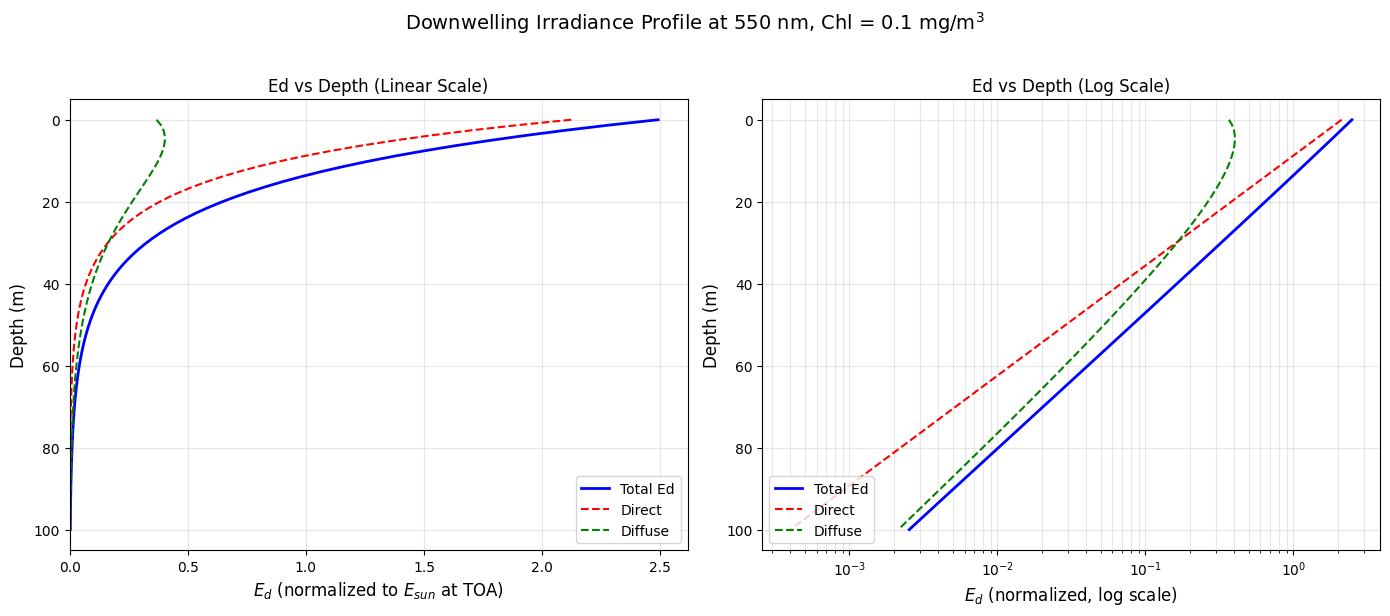

In [5]:
def plot_ed_profile(results: Dict, title: str = None):
    """
    Plot downwelling irradiance (Ed) as a function of depth.
    """
    if 'flux_data' not in results:
        print("No flux data available")
        return
    
    flux = results['flux_data']
    
    # Get ocean-only profile
    z = flux['z']
    ocean_mask = z < 0
    depth = -z[ocean_mask]  # Convert to positive depth
    Ed = flux['Ed_total'][ocean_mask]
    Ed_direct = flux['Ed_direct'][ocean_mask]
    Ed_diffuse = flux['Ed_diffuse'][ocean_mask]
    
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    
    # Plot 1: Linear scale
    axes[0].plot(Ed, depth, 'b-', linewidth=2, label='Total Ed')
    axes[0].plot(Ed_direct, depth, 'r--', linewidth=1.5, label='Direct')
    axes[0].plot(Ed_diffuse, depth, 'g--', linewidth=1.5, label='Diffuse')
    axes[0].set_xlabel(r'$E_d$ (normalized to $E_{sun}$ at TOA)', fontsize=12)
    axes[0].set_ylabel('Depth (m)', fontsize=12)
    axes[0].set_title('Ed vs Depth (Linear Scale)', fontsize=12)
    axes[0].invert_yaxis()  # Depth increases downward
    axes[0].legend(loc='lower right')
    axes[0].grid(True, alpha=0.3)
    axes[0].set_xlim(left=0)
    
    # Plot 2: Log scale (shows exponential attenuation)
    axes[1].semilogx(Ed, depth, 'b-', linewidth=2, label='Total Ed')
    axes[1].semilogx(Ed_direct, depth, 'r--', linewidth=1.5, label='Direct')
    axes[1].semilogx(Ed_diffuse, depth, 'g--', linewidth=1.5, label='Diffuse')
    axes[1].set_xlabel(r'$E_d$ (normalized, log scale)', fontsize=12)
    axes[1].set_ylabel('Depth (m)', fontsize=12)
    axes[1].set_title('Ed vs Depth (Log Scale)', fontsize=12)
    axes[1].invert_yaxis()
    axes[1].legend(loc='lower left')
    axes[1].grid(True, alpha=0.3, which='both')
    
    if title:
        fig.suptitle(title, fontsize=14, y=1.02)
    else:
        wl = results['params'].get('OSOAA.Wa', 0) * 1000
        chl = results['params'].get('PHYTO.Chl', '?')
        fig.suptitle(f'Downwelling Irradiance Profile at {wl:.0f} nm, Chl = {chl} mg/m$^3$', 
                     fontsize=14, y=1.02)
    
    plt.tight_layout()
    return fig, axes

# Plot the results
plot_ed_profile(results)
plt.show()

## 5. Calculating the Diffuse Attenuation Coefficient (Kd)

We can estimate Kd from the slope of ln(Ed) vs depth.

In [6]:
def calculate_kd(depth: np.ndarray, Ed: np.ndarray, 
                 depth_range: tuple = None) -> Dict:
    """
    Calculate diffuse attenuation coefficient Kd from Ed profile.
    
    Uses linear regression on ln(Ed) vs depth.
    
    Parameters
    ----------
    depth : array
        Depth values (positive, in meters)
    Ed : array
        Downwelling irradiance values
    depth_range : tuple, optional
        (min_depth, max_depth) to use for fitting
        
    Returns
    -------
    dict with Kd, Ed0, r_squared, and fitted values
    """
    # Apply depth range filter if specified
    if depth_range:
        mask = (depth >= depth_range[0]) & (depth <= depth_range[1])
        depth_fit = depth[mask]
        Ed_fit = Ed[mask]
    else:
        depth_fit = depth
        Ed_fit = Ed
    
    # Filter out zero or negative values
    valid_mask = Ed_fit > 0
    depth_fit = depth_fit[valid_mask]
    Ed_fit = Ed_fit[valid_mask]
    
    # Linear regression on ln(Ed) vs depth
    ln_Ed = np.log(Ed_fit)
    
    # Fit: ln(Ed) = ln(Ed0) - Kd * z
    coeffs = np.polyfit(depth_fit, ln_Ed, 1)
    Kd = -coeffs[0]  # Negative of slope
    Ed0 = np.exp(coeffs[1])  # Intercept gives Ed at z=0
    
    # Calculate R-squared
    ln_Ed_fitted = np.polyval(coeffs, depth_fit)
    ss_res = np.sum((ln_Ed - ln_Ed_fitted)**2)
    ss_tot = np.sum((ln_Ed - np.mean(ln_Ed))**2)
    r_squared = 1 - ss_res / ss_tot
    
    return {
        'Kd': Kd,
        'Ed0': Ed0,
        'r_squared': r_squared,
        'depth_fit': depth_fit,
        'Ed_fitted': np.exp(ln_Ed_fitted),
        'euphotic_depth': 4.6 / Kd if Kd > 0 else np.nan,  # Depth where Ed = 1% of surface
    }

# Calculate Kd for our simulation
if 'flux_data' in results:
    ocean_ed = sim.get_ocean_ed_profile(results['flux_data'])
    kd_results = calculate_kd(ocean_ed['depth'], ocean_ed['Ed'])
    
    print(f"Diffuse attenuation coefficient analysis:")
    print(f"  Kd = {kd_results['Kd']:.4f} m^-1")
    print(f"  Ed(0-) = {kd_results['Ed0']:.6f}")
    print(f"  R-squared = {kd_results['r_squared']:.6f}")
    print(f"  Euphotic depth (1% light level) = {kd_results['euphotic_depth']:.1f} m")

Diffuse attenuation coefficient analysis:
  Kd = 0.0691 m^-1
  Ed(0-) = 2.564614
  R-squared = 0.999979
  Euphotic depth (1% light level) = 66.6 m


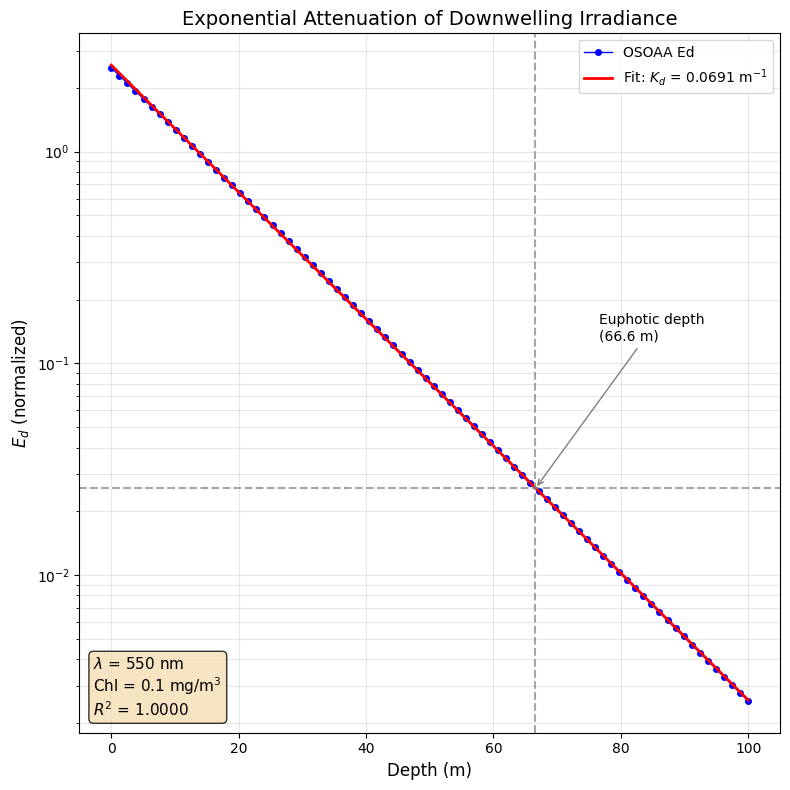

In [7]:
def plot_ed_with_fit(results: Dict, kd_results: Dict):
    """
    Plot Ed profile with exponential fit and Kd annotation.
    """
    flux = results['flux_data']
    z = flux['z']
    ocean_mask = z < 0
    depth = -z[ocean_mask]
    Ed = flux['Ed_total'][ocean_mask]
    
    fig, ax = plt.subplots(figsize=(8, 8))
    
    # Plot data
    ax.semilogy(depth, Ed, 'bo-', markersize=4, linewidth=1, label='OSOAA Ed')
    
    # Plot fit
    depth_fit_full = np.linspace(0, depth.max(), 100)
    Ed_fit_full = kd_results['Ed0'] * np.exp(-kd_results['Kd'] * depth_fit_full)
    ax.semilogy(depth_fit_full, Ed_fit_full, 'r-', linewidth=2, 
                label=f'Fit: $K_d$ = {kd_results["Kd"]:.4f} m$^{{-1}}$')
    
    # Mark euphotic depth
    z_eu = kd_results['euphotic_depth']
    if z_eu < depth.max():
        Ed_eu = kd_results['Ed0'] * 0.01
        ax.axhline(y=Ed_eu, color='gray', linestyle='--', alpha=0.7)
        ax.axvline(x=z_eu, color='gray', linestyle='--', alpha=0.7)
        ax.annotate(f'Euphotic depth\n({z_eu:.1f} m)', 
                   xy=(z_eu, Ed_eu), xytext=(z_eu + 10, Ed_eu * 5),
                   fontsize=10, arrowprops=dict(arrowstyle='->', color='gray'))
    
    ax.set_xlabel('Depth (m)', fontsize=12)
    ax.set_ylabel(r'$E_d$ (normalized)', fontsize=12)
    ax.set_title('Exponential Attenuation of Downwelling Irradiance', fontsize=14)
    ax.legend(loc='upper right')
    ax.grid(True, alpha=0.3, which='both')
    
    # Add text box with parameters
    wl = results['params'].get('OSOAA.Wa', 0) * 1000
    chl = results['params'].get('PHYTO.Chl', '?')
    textstr = f'$\\lambda$ = {wl:.0f} nm\nChl = {chl} mg/m$^3$\n$R^2$ = {kd_results["r_squared"]:.4f}'
    ax.text(0.02, 0.02, textstr, transform=ax.transAxes, fontsize=11,
            verticalalignment='bottom', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))
    
    plt.tight_layout()
    return fig, ax

if 'flux_data' in results:
    plot_ed_with_fit(results, kd_results)
    plt.show()

## 6. Effect of Chlorophyll Concentration on Ed Profile

Chlorophyll absorbs light (especially blue wavelengths), affecting the attenuation coefficient Kd. Let's compare Ed profiles for different chlorophyll concentrations.

In [8]:
# Chlorophyll concentration series
chl_values = [0.03, 0.1, 0.3, 1.0, 3.0]  # mg/m^3

chl_results = {}

print("Running chlorophyll series simulations at 550 nm...\n")
for chl in chl_values:
    params = sim.get_default_params(
        wavelength_nm=550.0,
        solar_zenith=30.0,
        chlorophyll=chl,
        aot=0.1,
        wind_speed=5.0,
        sea_depth=100.0
    )
    
    try:
        chl_results[chl] = sim.run(params, verbose=False)
        print(f"  Chl = {chl:5.2f} mg/m^3 - Done")
    except Exception as e:
        print(f"  Chl = {chl:5.2f} mg/m^3 - Failed: {e}")

print("\nAll simulations completed!")

Running chlorophyll series simulations at 550 nm...

  Chl =  0.03 mg/m^3 - Done
  Chl =  0.10 mg/m^3 - Done
  Chl =  0.30 mg/m^3 - Done
  Chl =  1.00 mg/m^3 - Done
  Chl =  3.00 mg/m^3 - Done

All simulations completed!


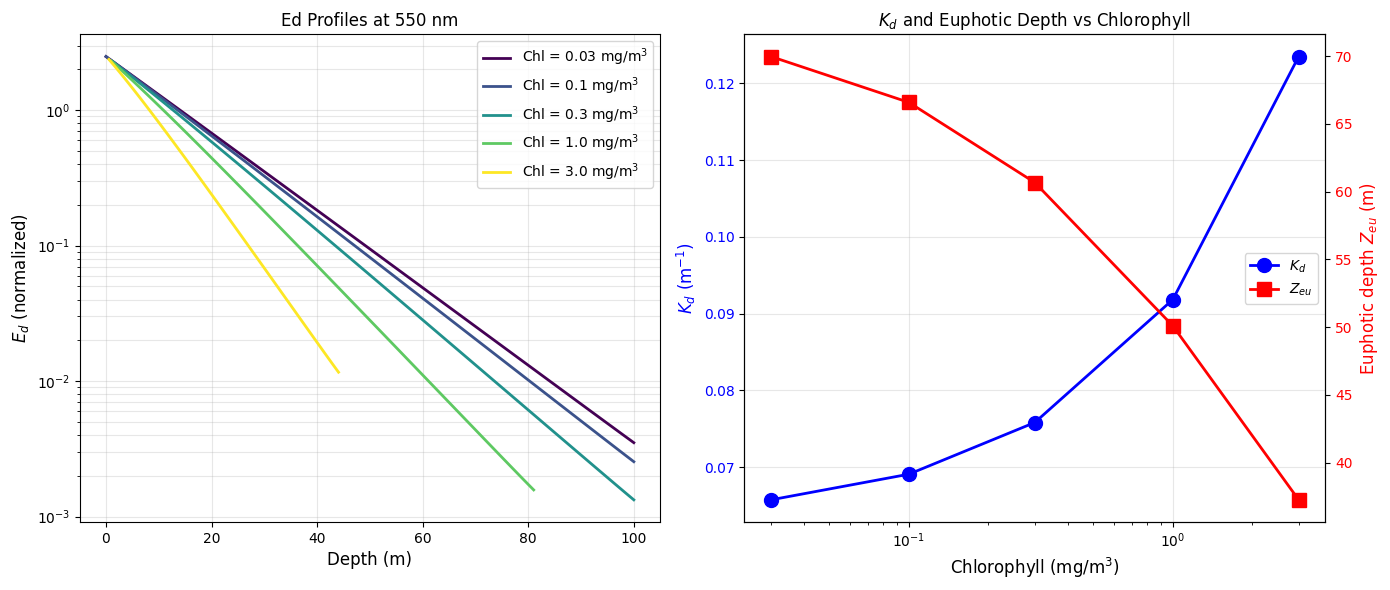

In [9]:
def plot_chlorophyll_ed_series(chl_results: Dict):
    """
    Compare Ed profiles for different chlorophyll concentrations.
    """
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    
    # Color map
    colors = plt.cm.viridis(np.linspace(0, 1, len(chl_results)))
    
    kd_values = []
    chl_vals = []
    z_eu_values = []
    
    for (chl, result), color in zip(sorted(chl_results.items()), colors):
        if 'flux_data' in result:
            flux = result['flux_data']
            z = flux['z']
            ocean_mask = z < 0
            depth = -z[ocean_mask]
            Ed = flux['Ed_total'][ocean_mask]
            
            # Plot Ed profile
            axes[0].semilogy(depth, Ed, '-', color=color, linewidth=2,
                            label=f'Chl = {chl} mg/m$^3$')
            
            # Calculate Kd
            kd_result = calculate_kd(depth, Ed)
            kd_values.append(kd_result['Kd'])
            z_eu_values.append(kd_result['euphotic_depth'])
            chl_vals.append(chl)
    
    axes[0].set_xlabel('Depth (m)', fontsize=12)
    axes[0].set_ylabel(r'$E_d$ (normalized)', fontsize=12)
    axes[0].set_title('Ed Profiles at 550 nm', fontsize=12)
    axes[0].legend(loc='upper right')
    axes[0].grid(True, alpha=0.3, which='both')
    
    # Plot Kd and euphotic depth vs chlorophyll
    ax1 = axes[1]
    ax2 = ax1.twinx()
    
    line1, = ax1.semilogx(chl_vals, kd_values, 'bo-', linewidth=2, markersize=10, label='$K_d$')
    line2, = ax2.semilogx(chl_vals, z_eu_values, 'rs-', linewidth=2, markersize=10, label='$Z_{eu}$')
    
    ax1.set_xlabel('Chlorophyll (mg/m$^3$)', fontsize=12)
    ax1.set_ylabel('$K_d$ (m$^{-1}$)', fontsize=12, color='blue')
    ax2.set_ylabel('Euphotic depth $Z_{eu}$ (m)', fontsize=12, color='red')
    
    ax1.tick_params(axis='y', labelcolor='blue')
    ax2.tick_params(axis='y', labelcolor='red')
    
    axes[1].set_title('$K_d$ and Euphotic Depth vs Chlorophyll', fontsize=12)
    
    # Combined legend
    lines = [line1, line2]
    labels = [l.get_label() for l in lines]
    ax1.legend(lines, labels, loc='center right')
    ax1.grid(True, alpha=0.3)
    
    plt.tight_layout()
    return fig

if chl_results:
    plot_chlorophyll_ed_series(chl_results)
    plt.show()

## 7. Spectral Variation of Ed Profiles

Light attenuation varies strongly with wavelength. Blue light penetrates deeper in clear water, while red light is absorbed quickly.

In [10]:
# Wavelength series (visible spectrum)
wavelengths_nm = [443, 490, 555, 670]  # nm

spectral_results = {}

print("Running spectral simulations for clear water (Chl = 0.1 mg/m^3)...\n")
for wl in wavelengths_nm:
    params = sim.get_default_params(
        wavelength_nm=float(wl),
        solar_zenith=30.0,
        chlorophyll=0.1,
        aot=0.1,
        wind_speed=5.0,
        sea_depth=100.0
    )
    
    try:
        spectral_results[wl] = sim.run(params, verbose=False)
        print(f"  lambda = {wl} nm - Done")
    except Exception as e:
        print(f"  lambda = {wl} nm - Failed: {e}")

print("\nSpectral simulations completed!")

Running spectral simulations for clear water (Chl = 0.1 mg/m^3)...

  lambda = 443 nm - Done
  lambda = 490 nm - Done
  lambda = 555 nm - Done
  lambda = 670 nm - Done

Spectral simulations completed!


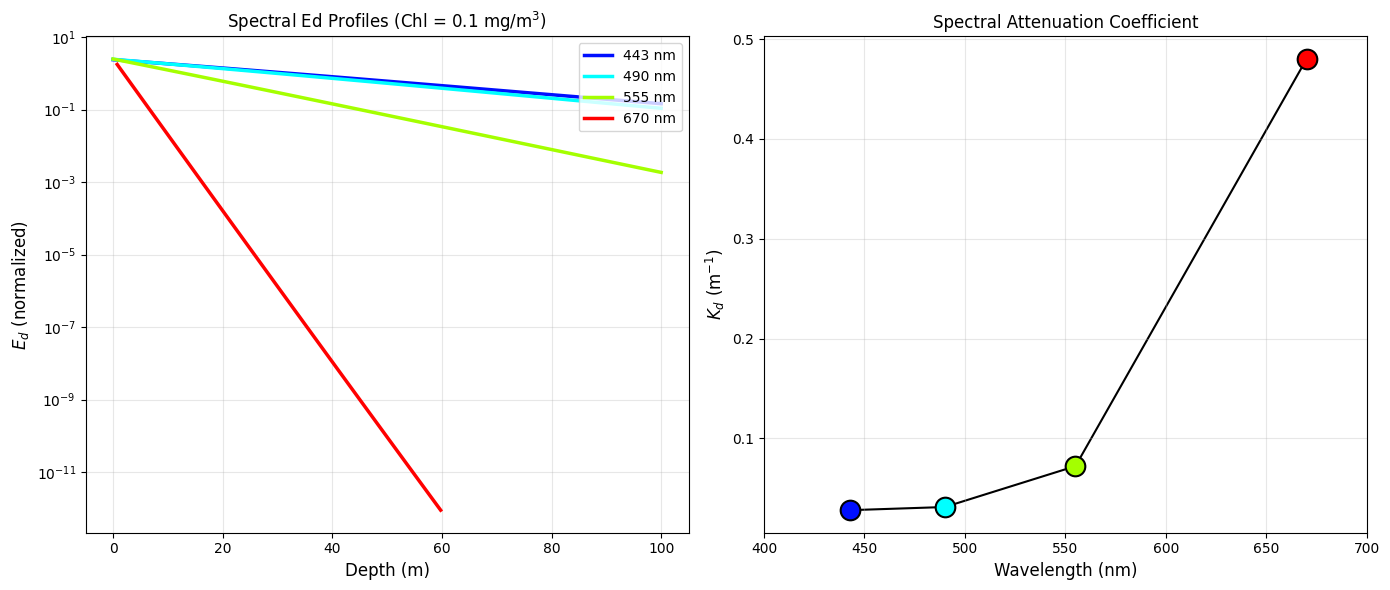

In [11]:
def wavelength_to_rgb(wavelength: float) -> tuple:
    """
    Convert wavelength (nm) to approximate RGB color.
    """
    if wavelength < 380:
        return (0.5, 0, 0.5)
    elif wavelength < 440:
        return (0.5 - 0.5*(wavelength-380)/(440-380), 0, 1)
    elif wavelength < 490:
        return (0, (wavelength-440)/(490-440), 1)
    elif wavelength < 510:
        return (0, 1, 1-(wavelength-490)/(510-490))
    elif wavelength < 580:
        return ((wavelength-510)/(580-510), 1, 0)
    elif wavelength < 645:
        return (1, 1-(wavelength-580)/(645-580), 0)
    elif wavelength < 780:
        return (1, 0, 0)
    else:
        return (0.5, 0, 0)

def plot_spectral_ed_profiles(spectral_results: Dict):
    """
    Plot Ed profiles for different wavelengths.
    """
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    
    kd_values = []
    wavelengths = []
    z_eu_values = []
    
    for wl, result in sorted(spectral_results.items()):
        if 'flux_data' in result:
            flux = result['flux_data']
            z = flux['z']
            ocean_mask = z < 0
            depth = -z[ocean_mask]
            Ed = flux['Ed_total'][ocean_mask]
            
            color = wavelength_to_rgb(wl)
            axes[0].semilogy(depth, Ed, '-', color=color, linewidth=2.5,
                            label=f'{wl} nm')
            
            # Calculate Kd
            kd_result = calculate_kd(depth, Ed)
            kd_values.append(kd_result['Kd'])
            z_eu_values.append(kd_result['euphotic_depth'])
            wavelengths.append(wl)
    
    axes[0].set_xlabel('Depth (m)', fontsize=12)
    axes[0].set_ylabel(r'$E_d$ (normalized)', fontsize=12)
    axes[0].set_title('Spectral Ed Profiles (Chl = 0.1 mg/m$^3$)', fontsize=12)
    axes[0].legend(loc='upper right')
    axes[0].grid(True, alpha=0.3, which='both')
    
    # Plot Kd spectrum
    for i, wl in enumerate(wavelengths):
        color = wavelength_to_rgb(wl)
        axes[1].scatter([wl], [kd_values[i]], c=[color], s=200, 
                       edgecolors='black', linewidth=1.5, zorder=2)
    axes[1].plot(wavelengths, kd_values, 'k-', linewidth=1.5, zorder=1)
    
    axes[1].set_xlabel('Wavelength (nm)', fontsize=12)
    axes[1].set_ylabel('$K_d$ (m$^{-1}$)', fontsize=12)
    axes[1].set_title('Spectral Attenuation Coefficient', fontsize=12)
    axes[1].grid(True, alpha=0.3)
    axes[1].set_xlim(400, 700)
    
    plt.tight_layout()
    return fig

if spectral_results:
    plot_spectral_ed_profiles(spectral_results)
    plt.show()

## 8. Complete Flux Profile: Atmosphere and Ocean

Let's visualize the complete flux profile from the top of atmosphere (TOA) through the ocean to the sea bottom.

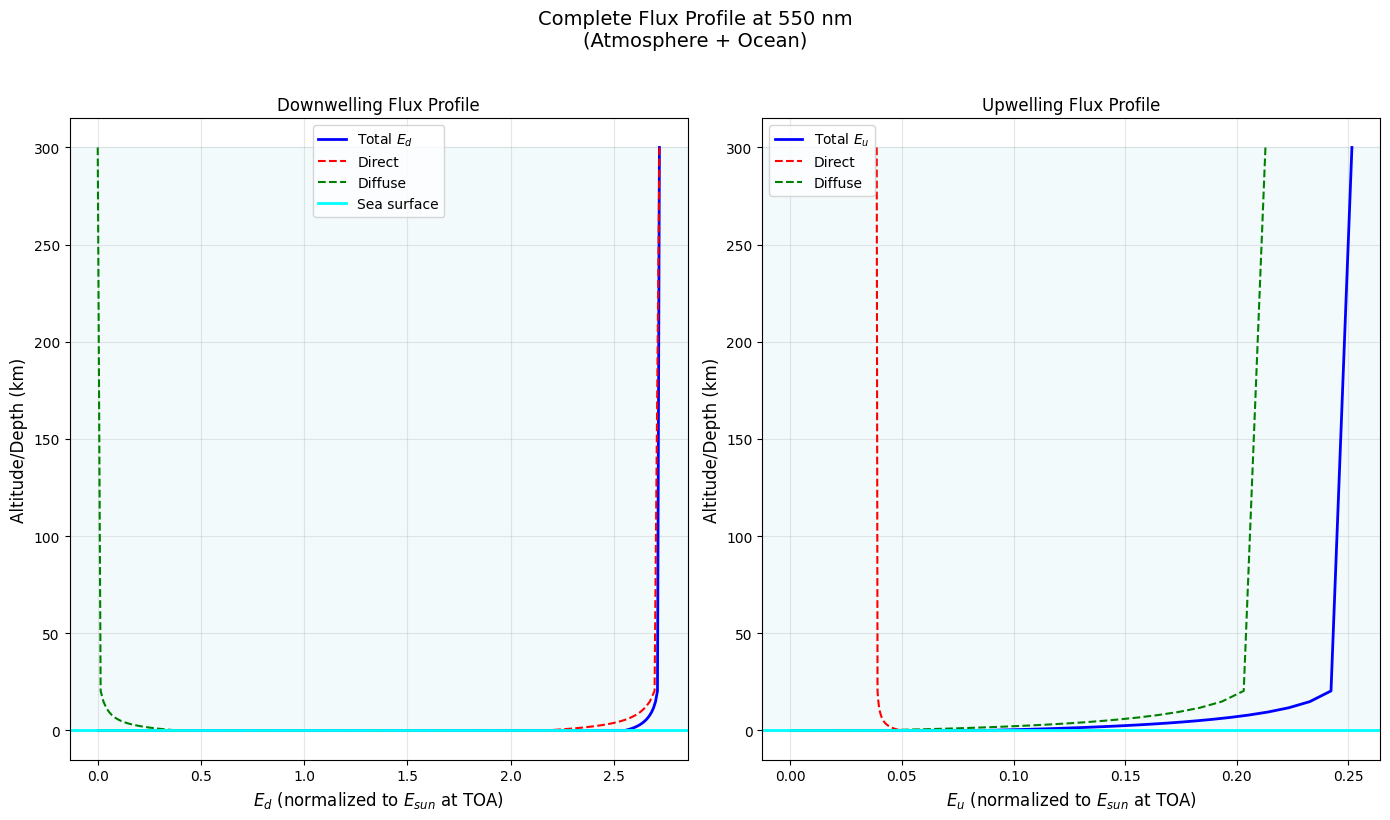

In [12]:
def plot_full_flux_profile(results: Dict):
    """
    Plot the complete flux profile from TOA to sea bottom.
    """
    if 'flux_data' not in results:
        print("No flux data available")
        return
    
    flux = results['flux_data']
    z = flux['z']  # Positive in atmosphere, negative in ocean
    
    fig, axes = plt.subplots(1, 2, figsize=(14, 8))
    
    # Plot 1: Downwelling flux
    axes[0].plot(flux['Ed_total'], z/1000, 'b-', linewidth=2, label='Total $E_d$')
    axes[0].plot(flux['Ed_direct'], z/1000, 'r--', linewidth=1.5, label='Direct')
    axes[0].plot(flux['Ed_diffuse'], z/1000, 'g--', linewidth=1.5, label='Diffuse')
    axes[0].axhline(y=0, color='cyan', linewidth=2, linestyle='-', label='Sea surface')
    axes[0].set_xlabel(r'$E_d$ (normalized to $E_{sun}$ at TOA)', fontsize=12)
    axes[0].set_ylabel('Altitude/Depth (km)', fontsize=12)
    axes[0].set_title('Downwelling Flux Profile', fontsize=12)
    axes[0].legend(loc='best')
    axes[0].grid(True, alpha=0.3)
    
    # Shade atmosphere and ocean
    axes[0].axhspan(0, z.max()/1000, alpha=0.1, color='skyblue', label='Atmosphere')
    axes[0].axhspan(z.min()/1000, 0, alpha=0.1, color='darkblue', label='Ocean')
    
    # Plot 2: Upwelling flux
    axes[1].plot(flux['Eu_total'], z/1000, 'b-', linewidth=2, label='Total $E_u$')
    axes[1].plot(flux['Eu_direct'], z/1000, 'r--', linewidth=1.5, label='Direct')
    axes[1].plot(flux['Eu_diffuse'], z/1000, 'g--', linewidth=1.5, label='Diffuse')
    axes[1].axhline(y=0, color='cyan', linewidth=2, linestyle='-')
    axes[1].set_xlabel(r'$E_u$ (normalized to $E_{sun}$ at TOA)', fontsize=12)
    axes[1].set_ylabel('Altitude/Depth (km)', fontsize=12)
    axes[1].set_title('Upwelling Flux Profile', fontsize=12)
    axes[1].legend(loc='best')
    axes[1].grid(True, alpha=0.3)
    
    axes[1].axhspan(0, z.max()/1000, alpha=0.1, color='skyblue')
    axes[1].axhspan(z.min()/1000, 0, alpha=0.1, color='darkblue')
    
    wl = results['params'].get('OSOAA.Wa', 0) * 1000
    fig.suptitle(f'Complete Flux Profile at {wl:.0f} nm\n(Atmosphere + Ocean)', 
                fontsize=14, y=1.02)
    
    plt.tight_layout()
    return fig, axes

# Plot using our first result
plot_full_flux_profile(results)
plt.show()

## 9. Summary Table: Kd and Euphotic Depth

Let's compile the results into a summary table.

In [13]:
def create_summary_table(results_dict: Dict, param_name: str, param_values: list):
    """
    Create a summary table of Kd and euphotic depth.
    """
    print(f"{'='*60}")
    print(f"Summary: Kd and Euphotic Depth vs {param_name}")
    print(f"{'='*60}")
    print(f"{param_name:>15} | {'Kd (m^-1)':>12} | {'Z_eu (m)':>10} | {'Ed(0-)':>12}")
    print(f"{'-'*15}-+-{'-'*12}-+-{'-'*10}-+-{'-'*12}")
    
    for val in param_values:
        if val in results_dict and 'flux_data' in results_dict[val]:
            flux = results_dict[val]['flux_data']
            z = flux['z']
            ocean_mask = z < 0
            depth = -z[ocean_mask]
            Ed = flux['Ed_total'][ocean_mask]
            
            kd_result = calculate_kd(depth, Ed)
            print(f"{val:>15} | {kd_result['Kd']:>12.4f} | {kd_result['euphotic_depth']:>10.1f} | {kd_result['Ed0']:>12.6f}")
    
    print(f"{'='*60}")

# Summary for chlorophyll series
if chl_results:
    create_summary_table(chl_results, 'Chl (mg/m^3)', chl_values)

print()

# Summary for spectral series
if spectral_results:
    create_summary_table(spectral_results, 'Wavelength (nm)', wavelengths_nm)

Summary: Kd and Euphotic Depth vs Chl (mg/m^3)
   Chl (mg/m^3) |    Kd (m^-1) |   Z_eu (m) |       Ed(0-)
----------------+--------------+------------+-------------
           0.03 |       0.0657 |       70.0 |     2.518345
            0.1 |       0.0691 |       66.6 |     2.564614
            0.3 |       0.0758 |       60.7 |     2.646974
            1.0 |       0.0918 |       50.1 |     2.741070
            3.0 |       0.1235 |       37.2 |     2.754154

Summary: Kd and Euphotic Depth vs Wavelength (nm)
Wavelength (nm) |    Kd (m^-1) |   Z_eu (m) |       Ed(0-)
----------------+--------------+------------+-------------
            443 |       0.0281 |      163.4 |     2.460282
            490 |       0.0313 |      147.0 |     2.524130
            555 |       0.0722 |       63.7 |     2.566795
            670 |       0.4800 |        9.6 |     2.433705


## 10. Key Physical Insights

### Downwelling Plane Irradiance ($E_d$)

The **downwelling plane irradiance** $E_d$ is the integral of downward radiance weighted by the cosine of the zenith angle:

$$E_d(z) = \int_{2\pi^-} L(z, \theta, \phi) \cos(\theta) d\Omega$$

### Beer-Lambert Attenuation

In the ocean, Ed attenuates approximately exponentially:

$$E_d(z) = E_d(0^-) \cdot e^{-K_d z}$$

where $K_d$ is the **diffuse attenuation coefficient**.

### Euphotic Zone

The **euphotic depth** $Z_{eu}$ is typically defined as the depth where $E_d$ falls to 1% of its surface value:

$$Z_{eu} = \frac{\ln(100)}{K_d} = \frac{4.6}{K_d}$$

### Factors Affecting $K_d$:

| Factor | Effect on $K_d$ |
|--------|----------------|
| **Wavelength** | Blue light has lower $K_d$ in clear water; red has high $K_d$ |
| **Chlorophyll** | Increases absorption, especially in blue and red |
| **CDOM** | Increases absorption in blue wavelengths |
| **Particles** | Increases scattering and absorption |
| **Solar angle** | Higher SZA = longer path = effective higher $K_d$ |

In [ ]:
# Clean up temporary files (optional)
cleanup = False  # Set to True to remove temporary files

if cleanup and hasattr(sim, 'work_dir'):
    print(f"Cleaning up: {sim.work_dir}")
    shutil.rmtree(sim.work_dir, ignore_errors=True)
else:
    print(f"Temporary files preserved in: {sim.work_dir}")
    print(f"Flux output file: {sim.work_dir / 'Advanced_outputs' / 'Flux.txt'}")